Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [788]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [789]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# FIX: Use the official public API path from pandas.errors
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 10 - Monte Carlo Simulations in Finance

## 10.1 Simulating stock price dynamics using geometric Brownian motion

### How to do it...

1. Import the libraries:

In [794]:
import numpy as np
import pandas as pd
import yfinance as yf

2. Download data from Yahoo Finance:

In [796]:
df = yf.download("IBM", 
                 start="2021-01-01", 
                  end="2022-12-31", # FIX: Use end of 2022 for a full test year
                  auto_adjust=True)   # FIX: Replaced 'adjusted' with 'auto_adjust'

[*********************100%***********************]  1 of 1 completed


3. Calculate and plot daily returns:

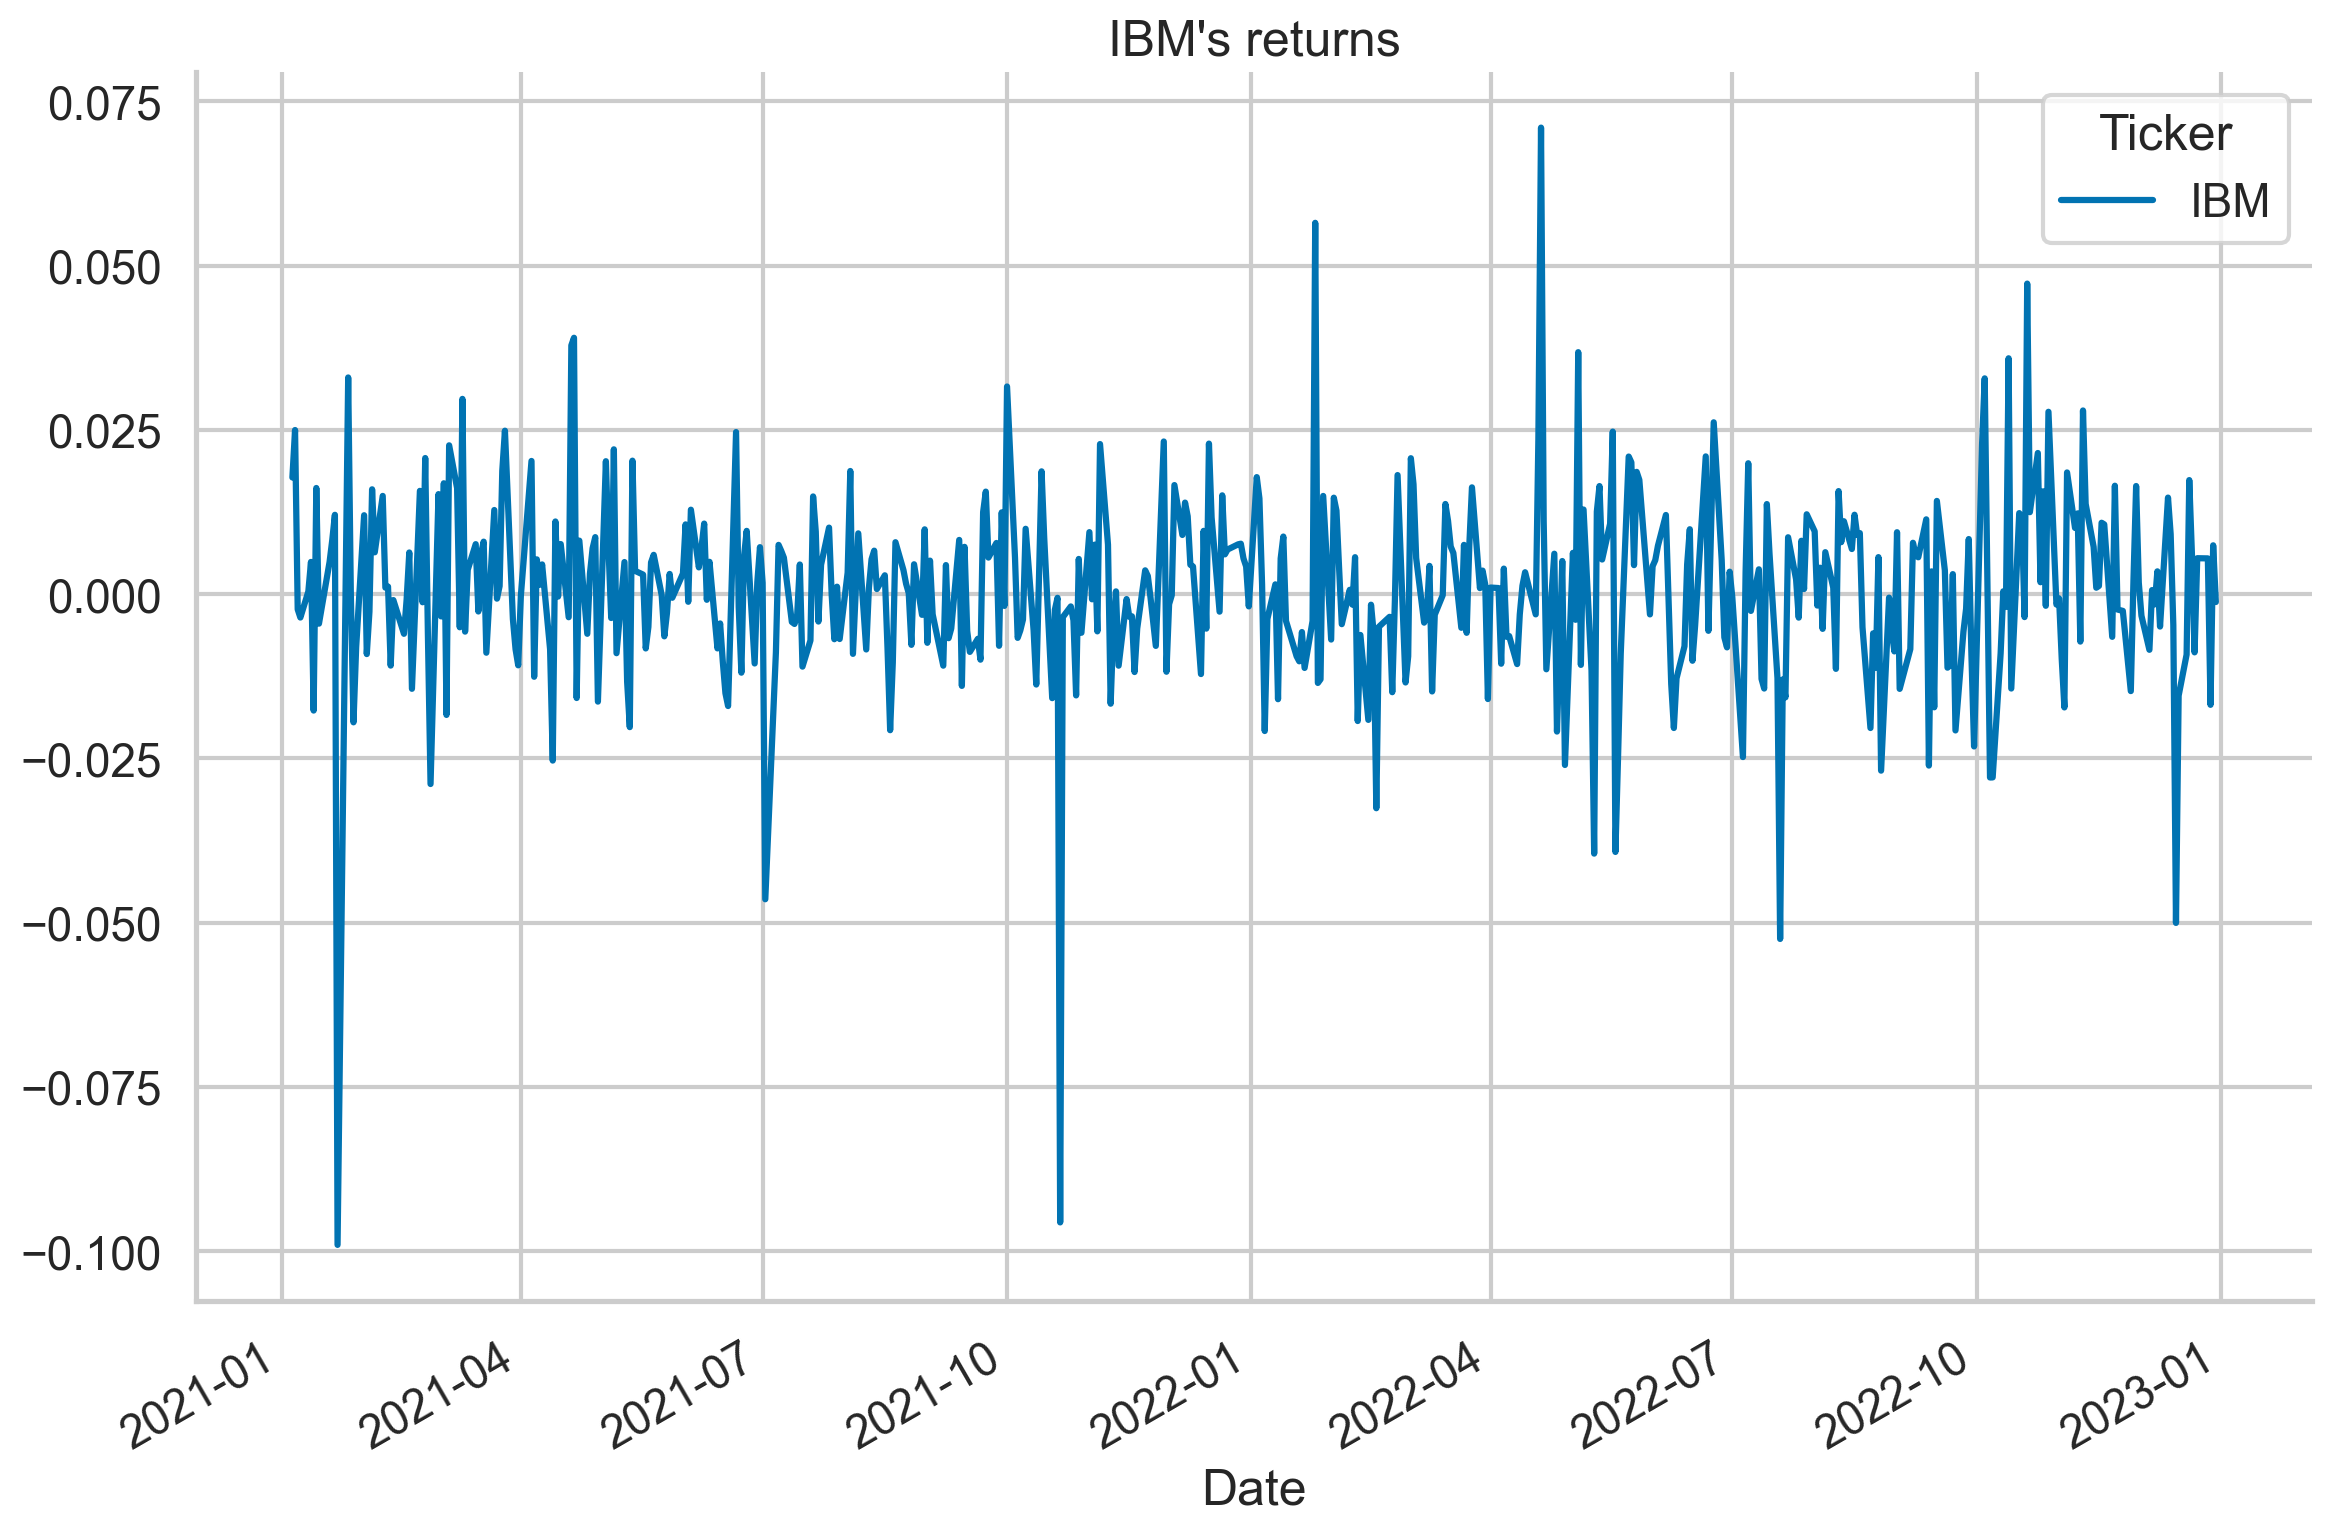

In [798]:
# FIX: Use the 'Close' column, which now contains the adjusted close price
returns = df["Close"].pct_change().dropna()

returns.plot(title="IBM's returns")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_10_1", dpi=200)

In [799]:
# FIX: Calculate the mean of the means to get a single number
average_return_all_stocks = returns.mean().mean()
print(f"Average return across all stocks: {100 * average_return_all_stocks:.2f}%")

Average return across all stocks: 0.06%


4. Split data into the training and test sets:

In [801]:

# FIX - Now perform the split on the correct 'returns' DataFrame
train = returns.loc["2021"]
test = returns.loc["2022"]

# (Optional) Print a confirmation to see that it worked
print("Train and test sets created successfully.")
print(f"Training data runs from {train.index.min().date()} to {train.index.max().date()}")
print(f"Testing data runs from {test.index.min().date()} to {test.index.max().date()}")



Train and test sets created successfully.
Training data runs from 2021-01-05 to 2021-12-31
Testing data runs from 2022-01-03 to 2022-12-30


95. Specify the parameters of the simulation:

In [803]:
# FIX: Use asof() to get the price on the last available date
# in df that is on or before the last date in the train set.
last_train_date = train.index[-1]
S_0 = df["Close"].asof(last_train_date)

# Now define the rest of your parameters
T = len(test)
N = len(test)
N_SIM = 100
mu = train.mean()
sigma = train.std()

6. Define the function used for simulations:

In [805]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42):
    """
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    """
    np.random.seed(random_seed)
    
    dt = T/N
    dW = np.random.normal(scale=np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    
    return S_t

7. Run the simulations and store the results in a DataFrame:

In [807]:
import yfinance as yf
import pandas as pd
import numpy as np

# Step 1: Download data and get the closing prices
df_close = yf.download("IBM", 
                       start="2010-01-01", 
                       end="2020-12-31", 
                       auto_adjust=True, 
                       progress=False)['Close']

# Step 2: Calculate returns and split the data
returns = df_close.pct_change().dropna()
test_size = 365
train = returns.iloc[:-test_size]
test = returns.iloc[-test_size:]

# Step 3: Define the simulation parameters
T = len(test)
N = len(test)
# FIX: Get the last price from the original 'Close' price series
S_0 = df_close.loc[train.index[-1]] 
N_SIM = 100

# FIX: Ensure mu and sigma are single float values
mu = train.mean()
sigma = train.std()

# Step 4: Run the simulation with guaranteed float values
# (This assumes the 'simulate_gbm' function is defined in a previous cell)
gbm_simulations = simulate_gbm(float(S_0), float(mu), float(sigma), N_SIM, T, N)

# Create the results DataFrame
sim_df = pd.DataFrame(np.transpose(gbm_simulations), 
                      index=train.index[-1:].union(test.index))

sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-22,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,...,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957
2019-07-23,110.044745,108.835018,109.637914,109.265278,109.187640,109.970569,107.243162,110.096120,108.410312,111.417008,...,110.279026,109.589710,108.575251,108.625805,105.121678,107.757758,108.861944,109.380753,109.155752,107.558817
2019-07-24,109.875628,109.153582,108.343117,109.389050,107.572000,108.522079,107.872763,106.598649,109.427104,110.983349,...,110.513420,111.730349,107.761163,109.969462,105.398041,108.411786,109.805912,109.578204,109.376159,107.862276
2019-07-25,110.773376,109.188420,108.906862,106.748572,107.313164,110.441598,110.612880,106.620573,109.183058,110.712702,...,110.613186,111.568367,106.784196,109.323269,106.136077,106.082416,108.069479,107.957608,110.164119,106.263823
2019-07-26,112.888390,109.337731,106.665491,107.977267,106.212860,110.325743,108.790002,107.069289,109.114722,109.878480,...,108.897189,112.449071,105.472552,107.744558,105.604198,105.708298,106.568734,107.661805,110.391422,105.195562


8. Create a DataFrame with the average value for each time step and the corresponding actual stock price:

In [809]:
res_df = sim_df.mean(axis=1).to_frame()

# FIX: Use the 'Close' column, which now contains the adjusted close price
res_df = res_df.join(df["Close"])

res_df.columns = ["simulation_average", "adj_close_price"]
res_df.head()

,simulation_average,adj_close_price
Date,,
2019-07-22,109.355957,NaN
2019-07-23,109.248946,NaN
2019-07-24,109.387506,NaN
2019-07-25,109.379796,NaN
2019-07-26,109.084404,NaN


9. Plot the results of the simulation:

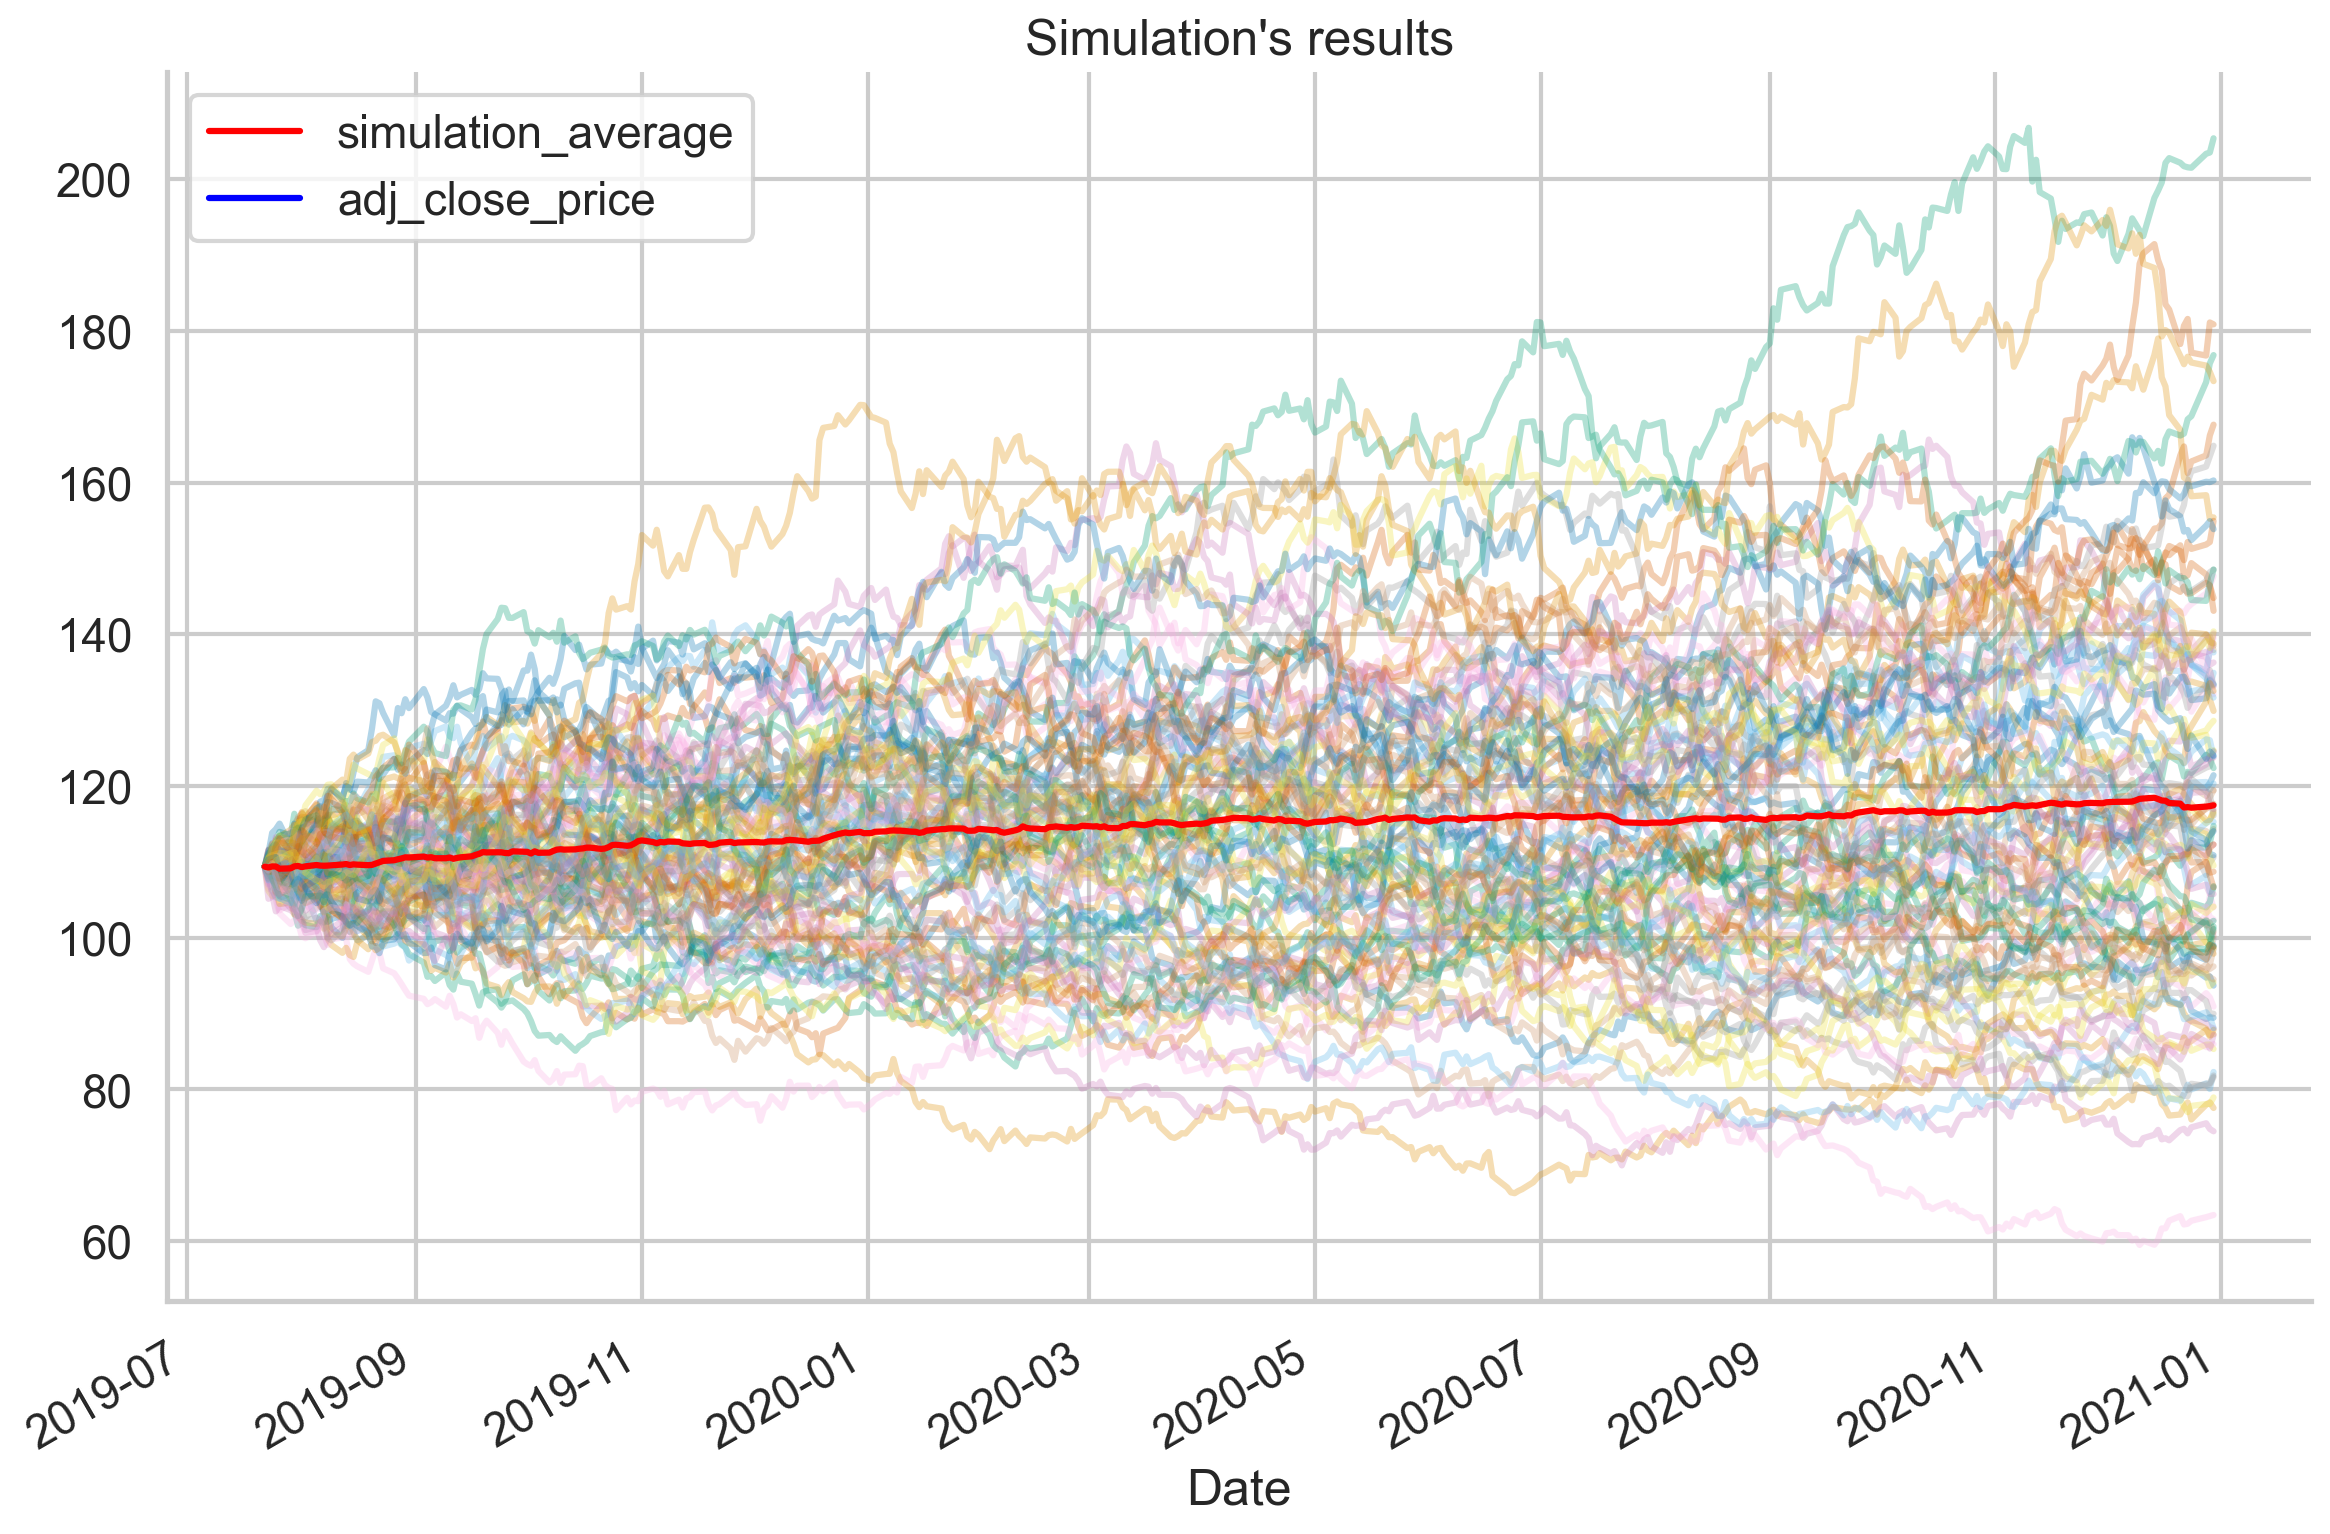

In [811]:
ax = sim_df.plot(
    alpha=0.3, 
    legend=False, 
    title="Simulation's results"
)
res_df.plot(ax=ax, color = ["red", "blue"])

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_10_2", dpi=200)

### There's more 

In [813]:
#Run the simulation with guaranteed float values
# (This assumes the 'simulate_gbm' function is defined in a previous cell)
gbm_simulations = simulate_gbm(float(S_0), float(mu), float(sigma), N_SIM, T, N)

# Create and display the results DataFrame
sim_df = pd.DataFrame(np.transpose(gbm_simulations), 
                      index=train.index[-1:].union(test.index))

sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-22,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,...,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957,109.355957
2019-07-23,110.044745,108.835018,109.637914,109.265278,109.187640,109.970569,107.243162,110.096120,108.410312,111.417008,...,110.279026,109.589710,108.575251,108.625805,105.121678,107.757758,108.861944,109.380753,109.155752,107.558817
2019-07-24,109.875628,109.153582,108.343117,109.389050,107.572000,108.522079,107.872763,106.598649,109.427104,110.983349,...,110.513420,111.730349,107.761163,109.969462,105.398041,108.411786,109.805912,109.578204,109.376159,107.862276
2019-07-25,110.773376,109.188420,108.906862,106.748572,107.313164,110.441598,110.612880,106.620573,109.183058,110.712702,...,110.613186,111.568367,106.784196,109.323269,106.136077,106.082416,108.069479,107.957608,110.164119,106.263823
2019-07-26,112.888390,109.337731,106.665491,107.977267,106.212860,110.325743,108.790002,107.069289,109.114722,109.878480,...,108.897189,112.449071,105.472552,107.744558,105.604198,105.708298,106.568734,107.661805,110.391422,105.195562


In [814]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, 
                 antithetic_var=False):
    """
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility
    antithetic_var : bool
        Boolean whether to use antithetic variates approach to reduce variance

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    """
    
    np.random.seed(random_seed)
    
    # time increment
    dt = T/N
    
    # Brownian
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), 
                              size=(n_sims, N + 1))
  
    # simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, 
                                 axis=1)) 
    S_t[:, 0] = s_0
    
    return S_t

## 10.2 Pricing European options using simulations 

### How to do it...

1. Import the libraries:

In [818]:
import numpy as np
from scipy.stats import norm
from chapter_10_utils import simulate_gbm

2. Define the parameters for the valuation:

In [820]:
S_0 = 100
K = 100
r = 0.05
sigma = 0.50
T = 1 # 1 year
N = 252 # 252 days in a year
dt = T / N # time step
N_SIMS = 1_000_000 # number of simulations 
discount_factor = np.exp(-r * T)

3. Define the valuation function using the analytical solution:

In [822]:
def black_scholes_analytical(S_0, K, T, r, sigma, type="call"):
    """
    Function used for calculating the price of European options using the
    analytical form of the Black-Scholes model.

    Parameters
    ------------
    s_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    type : str
        Type of the option. Can be one of the following: ["call", "put"]

    Returns
    -----------
    option_premium : float
        The premium on the option calculated using the Black-Scholes model
    """

    d1 = (
        np.log(S_0/K) + (r+0.5*sigma**2) * T) / (sigma*np.sqrt(T)
    )
    d2 = d1 - sigma * np.sqrt(T)
    if type == "call":
        N_d1 = norm.cdf(d1, 0, 1)
        N_d2 = norm.cdf(d2, 0, 1)
        val = S_0 * N_d1 - K * np.exp(-r * T) * N_d2
    elif type == "put":
        N_d1 = norm.cdf(-d1, 0, 1)
        N_d2 = norm.cdf(-d2, 0, 1)
        val = K * np.exp(-r * T) * N_d2 - S_0 * N_d1
    else:
        raise ValueError("Wrong input for type!")

    return val


4. Valuate the call option using the specified parameters:

In [824]:
black_scholes_analytical(S_0=S_0, K=K, T=T, 
                         r=r, sigma=sigma, 
                         type="call")

np.float64(21.79260421286685)

5. Simulate the stock path using the `simulate_gbm`  function: 

In [ ]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, 
                        n_sims=N_SIMS, T=T, N=N)

6. Calculate the option's premium:

In [ ]:
premium = (
    discount_factor * np.mean(np.maximum(0, gbm_sims[:, -1] - K))
)
premium

### There's more

1. Calculate the option premium for the European put option using the analytical formula:

In [ ]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type="put")

2. Define the modified simulation function, which only looks at the terminal values of the simulation paths:

In [ ]:
def european_option_simulation(S_0, K, T, r, sigma, n_sims, 
                               type="call", random_seed=42):
    """
    Function used for calculating the price of European options using Monte Carlo simulations.
    
    Parameters
    ------------
    S_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    n_sims : int
        Number of paths to simulate
    type : str
        Type of the option. Can be one of the following: ["call", "put"]
    random_seed : int
        Random seed for reproducibility
        
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using Monte Carlo simulations
    """
    np.random.seed(random_seed)
    rv = np.random.normal(0, 1, size=n_sims)
    S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * rv)

    if type == "call":
        payoff = np.maximum(0, S_T - K)
    elif type == "put":
        payoff = np.maximum(0, K - S_T)
    else: 
        raise ValueError("Wrong input for type!")
        
    premium = np.mean(payoff) * np.exp(-r * T)
    return premium

3. Run the simulations for the European put option:

In [ ]:
european_option_simulation(S_0, K, T, r, sigma, N_SIMS, type="put")

## 10.3 Pricing American options with Least Squares Monte Carlo

### How to do it...

1. Import the libraries:

In [ ]:
import numpy as np
from chapter_10_utils import (simulate_gbm, 
                              black_scholes_analytical, 
                              lsmc_american_option)

2. Define the parameters:

In [ ]:
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
T = 1 # 1 year
N = 50 
dt = T / N 
N_SIMS = 10 ** 5 
discount_factor = np.exp(-r * dt)
OPTION_TYPE = "put"
POLY_DEGREE = 5 

3. Simulate the stock prices using GBM:

In [ ]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=N_SIMS, 
                        T=T, N=N)

4. Calculate the payoff matrix:

In [ ]:
payoff_matrix = np.maximum(K - gbm_sims, np.zeros_like(gbm_sims))

5. Define the value matrix and fill in the last column (time T):

In [ ]:
value_matrix = np.zeros_like(payoff_matrix)
value_matrix[:, -1] = payoff_matrix[:, -1]

6. Iteratively calculate the continuation value and the value vector in the given time:

In [ ]:
for t in range(N - 1, 0 , -1):
    regression = np.polyfit(gbm_sims[:, t], 
                            value_matrix[:, t + 1] * discount_factor, 
                            POLY_DEGREE)
    continuation_value = np.polyval(regression, gbm_sims[:, t])
    value_matrix[:, t] = np.where(
        payoff_matrix[:, t] > continuation_value,
        payoff_matrix[:, t],
        value_matrix[:, t + 1] * discount_factor
    )

7. Calculate the option's premium:

In [ ]:
option_premium = np.mean(value_matrix[:, 1] * discount_factor)
option_premium

8. Calculate the premium of a European put with the same parameters:

In [ ]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, 
                         type="put")

9. As an extra check, calculate the prices of the American and European call options:

In [ ]:
european_call_price = black_scholes_analytical(S_0=S_0, K=K, T=T, 
                                               r=r, sigma=sigma)
american_call_price = lsmc_american_option(S_0=S_0, K=K, T=T, N=N, r=r, 
                                           sigma=sigma, n_sims=N_SIMS, 
                                           option_type="call", 
                                           poly_degree=POLY_DEGREE)
print(f"European call's price: {european_call_price:.3f}")
print(f"American call's price: {american_call_price:.3f}")

## 10.4 Pricing American options using Quantlib

### Getting ready

This setup is the same as Step 2 in the previous recipe.

In [ ]:
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
N = 50
N_SIMS = 10 ** 5 
OPTION_TYPE = "put"
POLY_DEGREE = 5 

### How to do it...

1. Import the library:

In [ ]:
import QuantLib as ql

2. Specify the calendar and the day counting convention:

In [ ]:
calendar = ql.UnitedStates()
day_counter = ql.ActualActual()

3. Specify the valuation date and the expiry date of the option:

In [ ]:
valuation_date = ql.Date(1, 1, 2020)
expiry_date =  ql.Date(1, 1, 2021)
ql.Settings.instance().evaluationDate = valuation_date

In [ ]:
T = day_counter.yearFraction(valuation_date, expiry_date)
print(f'Time to expiry in years: {T}') 

4. Define the option type (call/put), type of exercise and the payoff:

In [ ]:
if OPTION_TYPE == 'call':
    option_type_ql = ql.Option.Call
elif OPTION_TYPE == 'put':
    option_type_ql = ql.Option.Put
        
exercise = ql.AmericanExercise(valuation_date, expiry_date)
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

5. Prepare the market-related data:

In [ ]:
u = ql.SimpleQuote(S_0)
r = ql.SimpleQuote(r)
sigma = ql.SimpleQuote(sigma)

6. Specify the market-related curves:

In [ ]:
# volatility = ql.BlackConstantVol(valuation_date, calendar, sigma, day_counter)
# risk_free_rate = ql.FlatForward(valuation_date, r, day_counter)
underlying = ql.QuoteHandle(u)
volatility = ql.BlackConstantVol(0, ql.TARGET(), 
                                 ql.QuoteHandle(sigma), 
                                 day_counter)
risk_free_rate = ql.FlatForward(0, ql.TARGET(), 
                                ql.QuoteHandle(r), 
                                day_counter)

7. Plug in the market-related data into the BS process:

In [ ]:
bs_process = ql.BlackScholesProcess(
    underlying,
    ql.YieldTermStructureHandle(risk_free_rate),
    ql.BlackVolTermStructureHandle(volatility),
)

8. Instantiate the Monte Carlo engine for the American options:

In [ ]:
engine = ql.MCAmericanEngine(bs_process, 'PseudoRandom', timeSteps=N, 
                             polynomOrder=POLY_DEGREE, 
                             seedCalibration=42, 
                             requiredSamples=N_SIMS)

9. Instantiate the `option` object and set its pricing engine:

In [ ]:
option = ql.VanillaOption(payoff, exercise)
option.setPricingEngine(engine)

10. Calculate the option's premium:

In [ ]:
option_premium_ql = option.NPV()
option_premium_ql

In [ ]:
print(f'The value of the American {OPTION_TYPE} option is: {option_premium_ql:.3f}')

### There's more

In [ ]:
u_0 = u.value() # original value
h = 0.01

u.setValue(u_0 + h)
P_plus_h = option.NPV()

u.setValue(u_0 - h)
P_minus_h = option.NPV()

u.setValue(u_0) # set back to the original value

delta = (P_plus_h - P_minus_h) / (2 * h)

print(f'Delta of the option: {delta:.2f}')

## 10.5 Pricing barrier options

### How to do it...

1. Import the libraries:

In [ ]:
import numpy as np
from chapter_10_utils import simulate_gbm

2. Define the parameters for the valuation:

In [ ]:
S_0 = 55
K = 60
BARRIER = 65 
r = 0.06
sigma = 0.2
T = 1 
N = 252 
dt = T / N 
N_SIMS = 10 ** 5
OPTION_TYPE = "call"
discount_factor = np.exp(-r * T)

3. Simulate the stock path using the `simulate_gbm`  function: 

In [ ]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, 
                        n_sims=N_SIMS, T=T, N=N)

4. Calculate the maximum value per path:

In [ ]:
max_value_per_path = np.max(gbm_sims, axis=1)

5. Calculate the payoff:

In [ ]:
payoff = np.where(max_value_per_path > BARRIER, 
                  np.maximum(0, gbm_sims[:, -1] - K), 
                  0)

6. Calculate the option's premium:

In [ ]:
premium = discount_factor * np.mean(payoff)
premium

### There's more

1. Import the library:

In [ ]:
import QuantLib as ql

2. Specify the calendar and the day counting convention:

In [ ]:
calendar = ql.UnitedStates()
day_counter = ql.ActualActual()

3. Specify the valuation date and the expiry date of the option:

In [ ]:
valuation_date = ql.Date(1, 1, 2020)
expiry_date =  ql.Date(1, 1, 2021)
ql.Settings.instance().evaluationDate = valuation_date

In [ ]:
T = day_counter.yearFraction(valuation_date, expiry_date)
print(f'Time to expiry in years: {T}') 

4. Define the option type (call/put), type of exercise and the payoff:

In [ ]:
if OPTION_TYPE == "call":
    option_type_ql = ql.Option.Call
elif OPTION_TYPE == "put":
    option_type_ql = ql.Option.Put
        
exercise = ql.EuropeanExercise(expiry_date)
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

5. Prepare the market-related data:

In [ ]:
u = ql.SimpleQuote(S_0)
r = ql.SimpleQuote(r)
sigma = ql.SimpleQuote(sigma)

6. Specify the market-related curves:

In [ ]:
underlying = ql.QuoteHandle(u)
volatility = ql.BlackConstantVol(0, ql.TARGET(), 
                                 ql.QuoteHandle(sigma), 
                                 day_counter)
risk_free_rate = ql.FlatForward(0, ql.TARGET(), 
                                ql.QuoteHandle(r), 
                                day_counter)

7. Plug in the market-related data into the BS process:

In [ ]:
bs_process = ql.BlackScholesProcess(
    underlying,
    ql.YieldTermStructureHandle(risk_free_rate),
    ql.BlackVolTermStructureHandle(volatility),
)

8. Instantiate the Monte Carlo engine for barrier options:

In [ ]:
engine = ql.MCBarrierEngine(bs_process, 'PseudoRandom', timeSteps=N, 
                            seed=42, 
                            requiredSamples=N_SIMS)

9. Instantiate the `option` object and set its pricing engine:

In [ ]:
option = ql.BarrierOption(ql.Barrier.UpIn, BARRIER, rebate=0, 
                          payoff=payoff, exercise=exercise)
option.setPricingEngine(engine)

10. Calculate the option's premium:

In [ ]:
option_premium_ql = option.NPV()
option_premium_ql

## 11.6 Estimating Value-at-risk using Monte Carlo

### How to do it...

1. Import the libraries:

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns

In [ ]:
# set random seed for reproducibility
np.random.seed(42)

2. Define the parameters that will be used for this recipe:

In [ ]:
RISKY_ASSETS = ["AMD", "INTC"]
SHARES = [5, 5]
START_DATE = "2020-01-01"
END_DATE = "2020-12-31"
T = 1
N_SIMS = 10 ** 5

3. Download data from Yahoo Finance:

In [ ]:
df = yf.download(RISKY_ASSETS,
                 start=START_DATE, 
                 end=END_DATE, 
                 auto_adjust=True,
                 timeout=30) # FIX: Added a 30-second timeout

In [ ]:
df.head()

4. Calculate daily returns:

In [ ]:
returns = df["Close"].pct_change().dropna()
returns.plot(title="Intel's and AMD's daily stock returns in 2020")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_10_3", dpi=200)

In [ ]:
print(f'Correlation between returns: {returns.corr().values[0,1]:.2f}')

5. Calculate the covariance matrix:

In [ ]:
cov_mat = returns.cov()
cov_mat

6. Perform the Cholesky decomposition of the covariance matrix:

In [ ]:
chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

7. Draw correlated random numbers from Standard Normal distribution:

In [ ]:
rv = np.random.normal(size=(N_SIMS, len(RISKY_ASSETS)))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

8. Define metrics used for simulations:

In [ ]:

# FIX: The SHARES array must match the number of tickers (in this case, 2)
SHARES = np.array([20, 15])

# Now your original code will work
r = np.mean(returns, axis=0).values
sigma = np.std(returns, axis=0).values
S_0 = df["Close"].values[-1, :]
P_0 = np.sum(SHARES * S_0)

# You can add a print statement to see the result
print(f"Initial Portfolio Value: ${P_0:,.2f}")

9. Calculate the terminal price of the considered stocks:

In [ ]:
S_T = S_0 * np.exp(
    (r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * correlated_rv
)

10. Calculate the terminal portfolio value and calculate the portfolio returns:

In [ ]:
P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0

11. Calculate VaR:

In [ ]:
P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f"1-day VaR with {100-x}% confidence: {-y:.2f}$")

12. Present the results on a graph:

In [ ]:
ax = sns.distplot(P_diff, kde=False)
ax.set_title("""Distribution of possible 1-day changes in portfolio value 
             1-day 99% VaR""", fontsize=16)
ax.axvline(var[2], 0, 10000)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_10_4", dpi=200)

### There's more

In [ ]:
var = np.percentile(P_diff_sorted, 5)
expected_shortfall = P_diff_sorted[P_diff_sorted<=var].mean()

print(f'The 1-day 95% VaR is {-var:.2f}$, and the accompanying Expected Shortfall is {-expected_shortfall:.2f}$.')